## Object detection with Single-shot Multibox detector

In this lab, we are going to recapitulate the concept of image detection, and to play around with the Single Shot MultiBox Detector, also known as SSD, to detect objects inside some images.

If you need to revisit what object detection and segmentation are, please take a look at the object detection and segmentation notebook first. It is located inside the same folder as this notebook you are reading right now :)

## Single-shot Multibox detector

SSD was originally [presented](https://arxiv.org/abs/1512.02325) at the end of November 2016 as a method for detecting objects in images using a single deep neural network, and has obtained very good results in experiments conducted using the PASCAL VOC, MS COCO, and ILSVRC datasets.

First, we are going to download [pierluigiferrari/ssd_keras](https://github.com/pierluigiferrari/ssd_keras), which is an implementation of SSD in keras.

In [ ]:
## We will clone Sebratec academy's fork of the project because of some keras compatibility issues documented here: https://github.com/pierluigiferrari/ssd_keras/issues/307

!git clone https://github.com/sebratec-academy/ssd_keras

After that, we also need to upgrade the code to tensorflow 2 to get rid of some more compatibility issues.

In [ ]:
!tf_upgrade_v2 --intree ssd_keras --inplace

Then, let's load the required classes and utilities from ssd_keras

In [ ]:
import os

# change to the correct path if we are not on it.
if("ssd_keras" not in os.getcwd()):
    os.chdir('ssd_keras')

import keras
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

This section sets the configuration parameters. The parameters below are set to produce the original SSD300 architecture that was trained on the Pascal VOC datasets.

In [ ]:
img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [123, 117, 104] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
swap_channels = [2, 1, 0] # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 20 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales_coco = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # The anchor box scaling factors used in the original SSD300 for the MS COCO datasets
scales = scales_pascal
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [8, 16, 32, 64, 100, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

Next, we need to build our model. SSD is built on top of the VGG16 network, and we are going to load the weights of a pre-trained VGG16 network into our model. Below, we are going to download the weights from our academy system, and unzip the weights.

In [ ]:
# Download the zipped weights from the academy system if not downloaded already
if not os.path.isfile("a97a5536ed4af6f6c901833dfb30f91e.rar"):
    !wget https://storage.googleapis.com/sebratec_academy/files/a97a5536ed4af6f6c901833dfb30f91e.rar

# Extract the compresses file if it was not extracted already
if not os.path.isfile("vgg_voc_weights.h5"):
    !unrar e -r "a97a5536ed4af6f6c901833dfb30f91e.rar"

# Delete the leftovers if they exist
if os.path.isfile("a97a5536ed4af6f6c901833dfb30f91e.rar"):
    ! rm "a97a5536ed4af6f6c901833dfb30f91e.rar"

Next, we will build our model and load the downloaded weights

In [ ]:
K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                l2_regularization=0.0005,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

weights_path = 'vgg_voc_weights.h5'

model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=sgd, loss=ssd_loss.compute_loss)

Then, we need to set up the data generators for the training proccess. The datasets are already downloaded and conveniently arranged for you.

In [ ]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=False, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets. This can take a while.

# The directories that contain the images.
VOC_2007_images_dir      = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2007/JPEGImages/'
VOC_2012_images_dir      = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2012/JPEGImages/'

# The directories that contain the annotations.
VOC_2007_annotations_dir      = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2007/Annotations/'
VOC_2012_annotations_dir      = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2012/Annotations/'

# The paths to the image sets.
VOC_2007_train_image_set_filename    = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2007/ImageSets/Main/train.txt'
VOC_2012_train_image_set_filename    = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2012/ImageSets/Main/train.txt'
VOC_2007_val_image_set_filename      = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2007/ImageSets/Main/val.txt'
VOC_2012_val_image_set_filename      = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2012/ImageSets/Main/val.txt'
VOC_2007_trainval_image_set_filename = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2007/ImageSets/Main/trainval.txt'
VOC_2012_trainval_image_set_filename = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2012/ImageSets/Main/trainval.txt'
VOC_2007_test_image_set_filename     = '/datasets/single-shot-multibox-detector/VOCdevkit/VOC2007/ImageSets/Main/test.txt'

# The XML parser needs to now what object class names to look for and in which order to map them to integers.
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

train_dataset.parse_xml(images_dirs=[VOC_2007_images_dir,
                                     VOC_2012_images_dir],
                        image_set_filenames=[VOC_2007_trainval_image_set_filename,
                                             VOC_2012_trainval_image_set_filename],
                        annotations_dirs=[VOC_2007_annotations_dir,
                                          VOC_2012_annotations_dir],
                        classes=classes,
                        include_classes='all',
                        exclude_truncated=False,
                        exclude_difficult=False,
                        ret=False)

val_dataset.parse_xml(images_dirs=[VOC_2007_images_dir],
                      image_set_filenames=[VOC_2007_test_image_set_filename],
                      annotations_dirs=[VOC_2007_annotations_dir],
                      classes=classes,
                      include_classes='all',
                      exclude_truncated=False,
                      exclude_difficult=True,
                      ret=False)

Below, a few more configurations. The only thing you need to worry here is the batch size. You can lower its value if you run into memory issues.

In [ ]:
# 3: Set the batch size.

batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.

# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=mean_color)

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.

# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv4_3_norm_mbox_conf').output_shape[1:3],
                   model.get_layer('fc7_mbox_conf').output_shape[1:3],
                   model.get_layer('conv6_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv7_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv8_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv9_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.

train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Decrease our learning rate as our epochs are increased

In [ ]:
# Define a learning rate schedule.

def lr_schedule(epoch):
    if epoch < 80:
        return 0.001
    elif epoch < 100:
        return 0.0001
    else:
        return 0.00001

A few callbacks. You are welcome to add a few more if you'd like. 

In [ ]:
# Define model callbacks.

model_checkpoint = ModelCheckpoint(filepath='ssd300_pascal_07+12_epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)
#model_checkpoint.best = 

csv_logger = CSVLogger(filename='ssd300_pascal_07+12_training_log.csv',
                       separator=',',
                       append=True)

learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule,
                                                verbose=1)

terminate_on_nan = TerminateOnNaN()

callbacks = [model_checkpoint,
             csv_logger,
             learning_rate_scheduler,
             terminate_on_nan]


This is our training function. Please note that this takes a lot of time already like this. Increasing these parameters will make the model take **a lot** more time to train.

In [ ]:
initial_epoch   = 0
final_epoch     = 1
steps_per_epoch = 2

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=final_epoch,
                              callbacks=callbacks,
                              validation_data=val_generator,
                              validation_steps=ceil(val_dataset_size/batch_size),
                              initial_epoch=initial_epoch)

Then, we can start making predictions. We will extract a few samples from our test dataset and try to draw our bounding boxes

In [16]:
predict_generator = val_dataset.generate(batch_size=1,
                                         shuffle=True,
                                         transformations=[convert_to_3_channels,
                                                          resize],
                                         label_encoder=None,
                                         returns={'processed_images',
                                                  'filenames',
                                                  'inverse_transform',
                                                  'original_images',
                                                  'original_labels'},
                                         keep_images_without_gt=False)

In [17]:
# 2: Generate samples.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))


Image: /datasets/single-shot-multibox-detector/VOCdevkit/VOC2007/JPEGImages/000655.jpg

Ground truth boxes:

[[ 15 199  81 359 296]
 [ 14 100 120 426 315]]


In [18]:
y_pred = model.predict(batch_images)

In [19]:

# 4: Decode the raw predictions in `y_pred`.

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.4,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

In [20]:

# 5: Convert the predictions for the original image.

y_pred_decoded_inv = apply_inverse_transforms(y_pred_decoded, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[ 14.   1. 106. 133. 427. 324.]
 [ 15.   1. 198.  85. 361. 297.]]


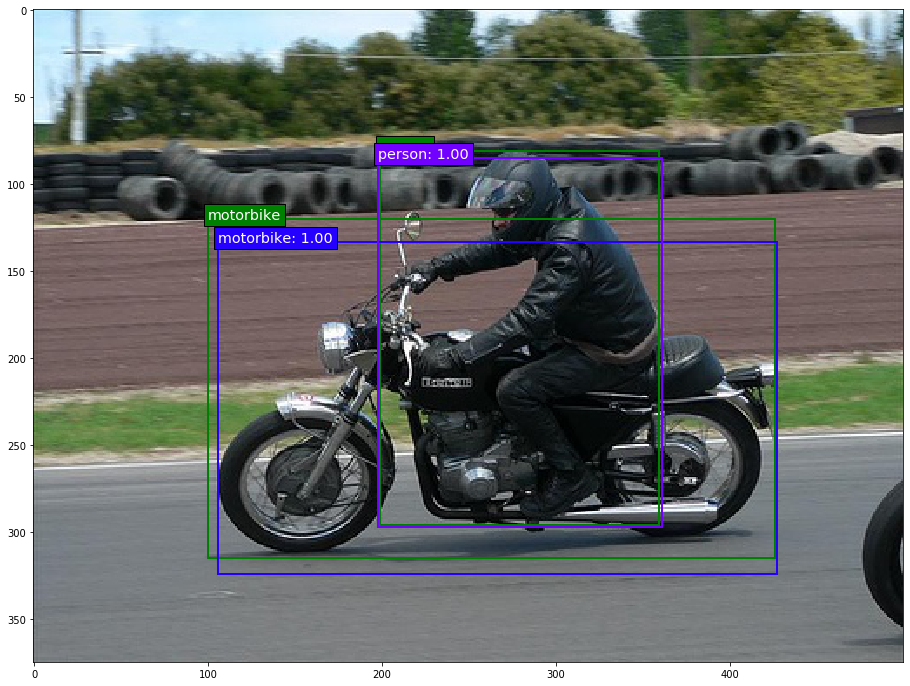

In [21]:

# 5: Draw the predicted boxes onto the image

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist()
classes = ['background',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat',
           'chair', 'cow', 'diningtable', 'dog',
           'horse', 'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor']

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_decoded_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})